In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from scipy import linalg
import matplotlib as mpl
import itertools

import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans

np.random.seed(42)

# Utilities

In [126]:
def SelBest(arr:list, X:int)->list:
    
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def load_data(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

def load_data_df(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    # X, y = X.to_numpy(), y.to_numpy()
    return X, y
    
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("EM Silhouette Scores to Personal Loan Dataset", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")

def generate_audit_time_plot(X, k):
    n_clusters=np.arange(2, k)
    train_time_kmean=[]
    query_time_kmean=[]
    train_time_em=[]
    query_time_em=[]
    iterations=k
    for n in n_clusters:
        start = time.time()
        kmeans=KMeans(n).fit(X)
        train_time_kmean_temp = time.time() - start

        start = time.time()
        kmeans.predict(X)
        query_time_kmean_temp = time.time() - start
        train_time_kmean.append(train_time_kmean_temp)
        query_time_kmean.append(query_time_kmean_temp)

        start = time.time()
        gmm=GaussianMixture(n).fit(X)
        train_time_em_temp = time.time() - start

        start = time.time()
        gmm.predict(X)
        query_time_em_temp = time.time() - start
        train_time_em.append(train_time_em_temp)
        query_time_em.append(query_time_em_temp)
    
    plt.plot(n_clusters, train_time_kmean, color='r', label="k-means train time")
    plt.plot(n_clusters, query_time_kmean, color='g', label="k-means query time")
    plt.plot(n_clusters, train_time_em, color='b', label="EM train time")
    plt.plot(n_clusters, query_time_em, color='m', label="EM query time")
    plt.title("Train and query time for the audit risk dataset", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("time")
    plt.legend(loc = "best")
    plt.show()

def generate_loan_time_plot(X, k):
    n_clusters=np.arange(2, k)
    train_time_kmean=[]
    query_time_kmean=[]
    train_time_em=[]
    query_time_em=[]
    iterations=k
    for n in n_clusters:
        start = time.time()
        kmeans=KMeans(n).fit(X)
        train_time_kmean_temp = time.time() - start

        start = time.time()
        kmeans.predict(X)
        query_time_kmean_temp = time.time() - start
        train_time_kmean.append(train_time_kmean_temp)
        query_time_kmean.append(query_time_kmean_temp)

        start = time.time()
        gmm=GaussianMixture(n).fit(X)
        train_time_em_temp = time.time() - start

        start = time.time()
        gmm.predict(X)
        query_time_em_temp = time.time() - start
        train_time_em.append(train_time_em_temp)
        query_time_em.append(query_time_em_temp)
    
    plt.plot(n_clusters, train_time_kmean, color='r', label="k-means train time")
    plt.plot(n_clusters, query_time_kmean, color='g', label="k-means query time")
    plt.plot(n_clusters, train_time_em, color='b', label="EM train time")
    plt.plot(n_clusters, query_time_em, color='m', label="EM query time")
    plt.title("Train and query time for the personal loan dataset", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("time")
    plt.legend(loc = "best")
    plt.show()

def generate_distance_bw_gmms_plots(X, n):
    
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    n_clusters=np.arange(2, n)
    iterations=n
    results=[]
    res_sigs=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(X, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
        selec=SelBest(np.array(dist), int(iterations/5))
        result=np.mean(selec)
        res_sig=np.std(selec)
        results.append(result)
        res_sigs.append(res_sig)


    plt.errorbar(n_clusters, results, yerr=res_sigs)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Distance")
    plt.show()

def generate_bic_plot(X, n):
    n_clusters=np.arange(2, n)
    bics=[]
    bics_err=[]
    iterations=n
    for n in n_clusters:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(X) 

            tmp_bic.append(gmm.bic(X))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)

    plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("grad(BIC)")
    plt.legend()
    plt.show()
    plt.clf()



# Audit Risk Dataset

The objective of this data is to assist auditors by constructing a classification model that can forecast fraudulent firms based on present and past risk factors.

## KMeans 

In [136]:
X, y = load_data('audit_risk.csv')

I ran SciKitLearn's k-means clustering over a range of k values from 2 to 21 to see how the performance varies between many clusters and very few clusters. 

I used the kmeans+++ (explain)

I generated a plot below showing the silhoutte scores for each value for number of clusters. 2 clusters has the highest score of ~0.95, which indicates that the clusters are very dense and very well separated from each other compared to the other higher k values with lower scores. Assuming there are no labels and we evaluate this as an unsupervised learning problem, it makes sense that k=2 would be the ideal number of clusters because the dataset is about the physical features of a specific body part. Intuition would say that an organ or body part can be grouped at the most basic level as healthy or not healthy given a set of datapoints describing the physical or chemical characteristics.

C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

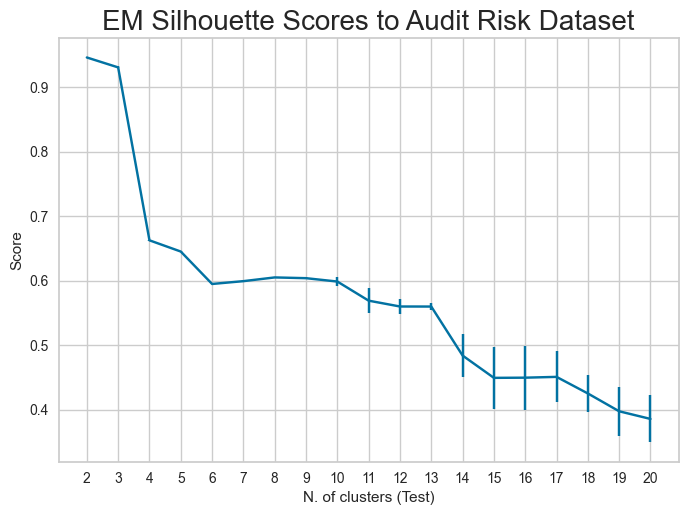

In [111]:
# Silhoutte Coef is used when the ground truth is not known
# Scores range from -1 to 1
# -1 being incorrect clustering
# 0 indicating overlapping
# 1 indicating highly dense clusters

generate_silhoutte_score_plot(X, 21, KMeans)

Figure 2 shows the silhoutte coefficient values for 2 clusters as well as a red line confirming the average silhoutte value of 0.95 shown earlier. Figure 3 shows that the clusters are very far from each other. One cluster is also significantly larger than the other cluster. The silhoutte score starts as we start to increase k past 2 clusters and overlapping between clusters is observed for k-values above 4. 

C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\ma

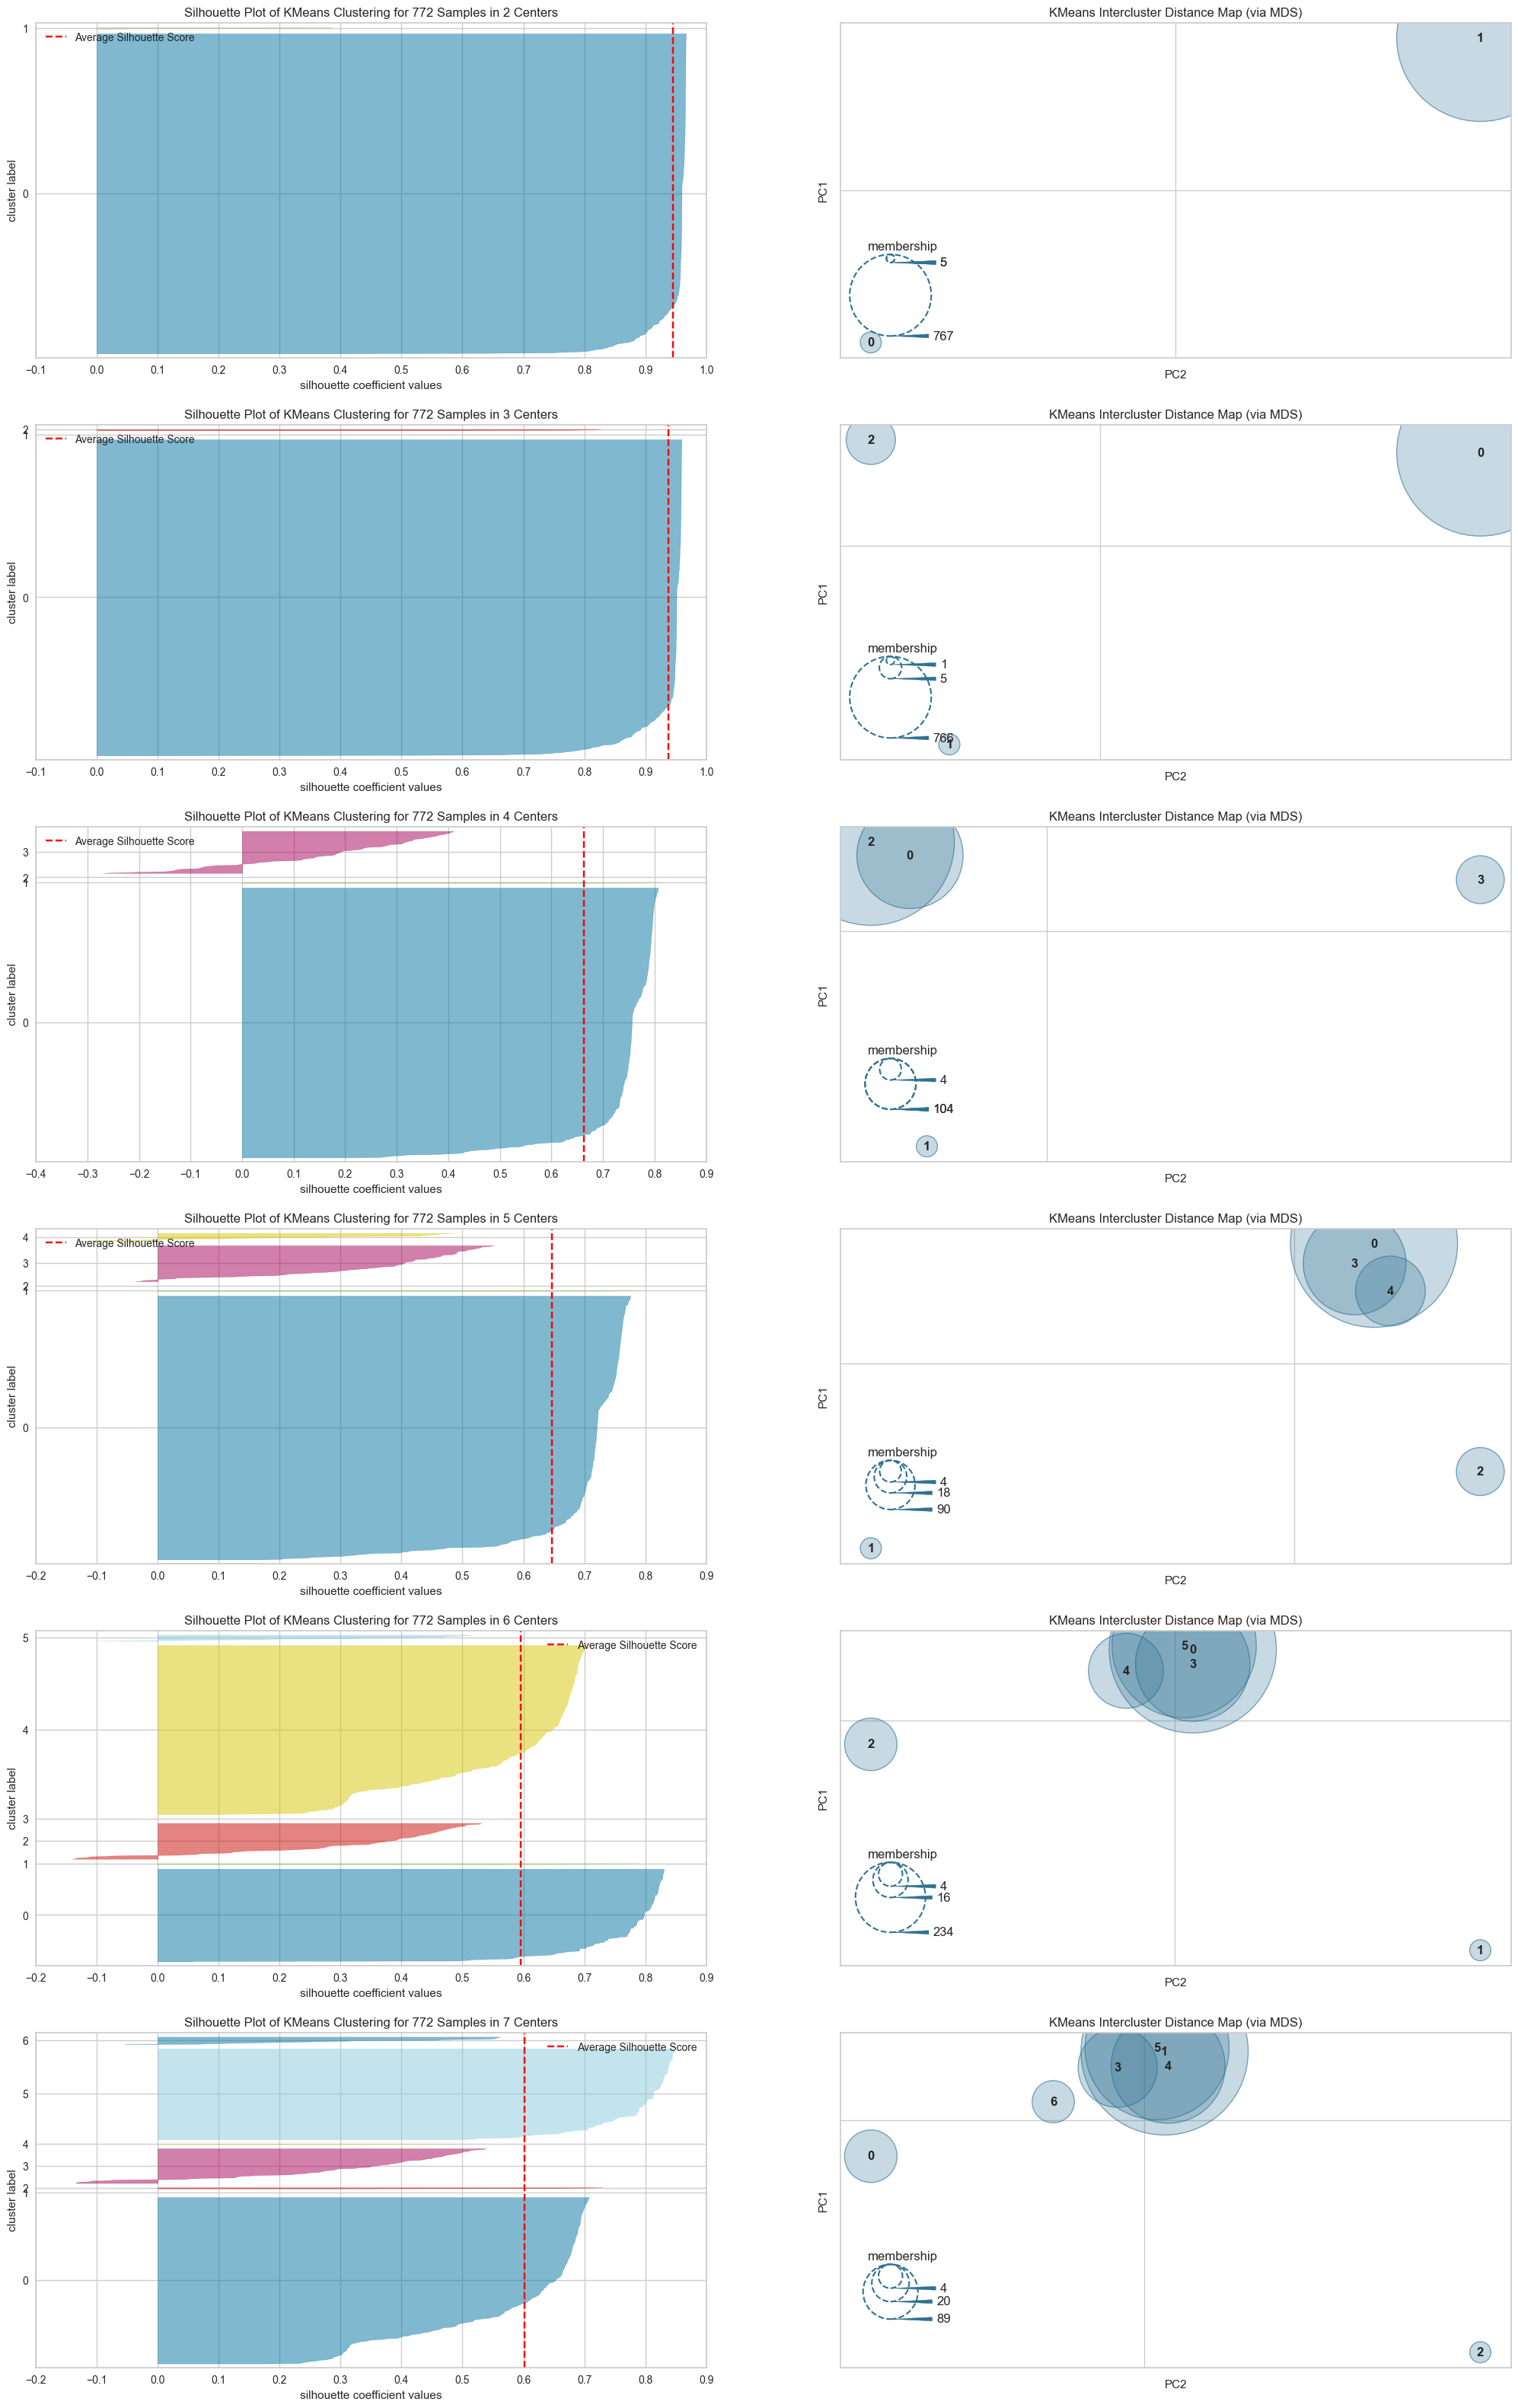

In [137]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X, k)

## Expected Maximization

In [113]:
X, y = load_data('audit_risk.csv')

I used the GaussianMixture model from SciKitLearn with the default settings to implement Expected Maximization. I tested the numbers 2 to 21 to find the optimal number of components. 

Figure 4 shows that 2 components produces the maximum silhoutte score, which is the same number of groupings as the KMeans implementation shown earlier with much silhoutte score.

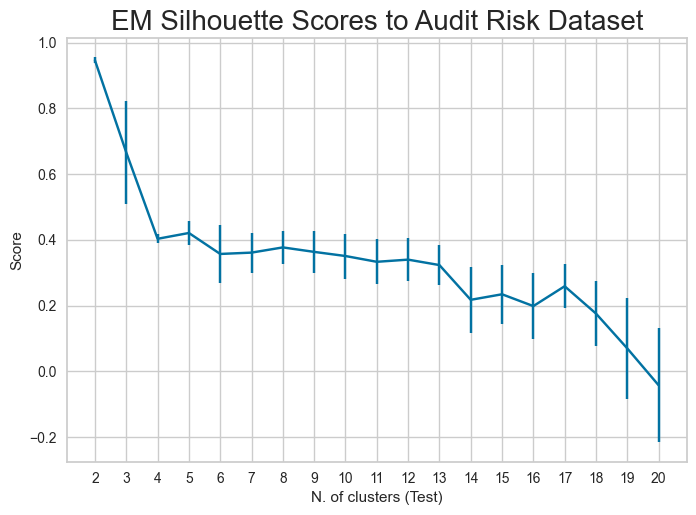

In [114]:
# generate_gmm_silhoutte_score_plot(X, 21)
generate_silhoutte_score_plot(X, 21, GaussianMixture)

Next I decided to calculate the distance between the Gaussian Mixture Models. This involves randomly generating two datasets then testing how similar the two models are with each other. The Jensen-Shannon metric is used to measure the distance between GMMs and what they say about the fit of the data. We see that the error increases when we go from 2 to 3 and that 2 components has the smallest Jensen-Shannon distance, so it is the ideal n-value for this problem set.

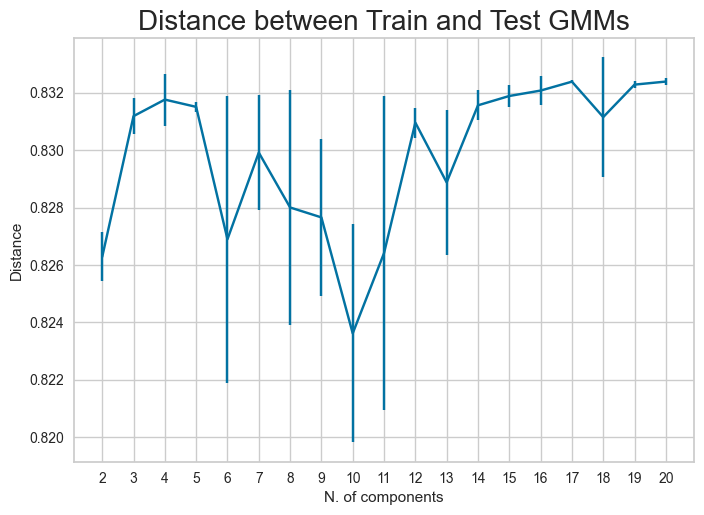

In [115]:
generate_distance_bw_gmms_plots(X, 21)

Here we see that 2 components has the lowest BIC (Bayesian Information Criterion) score, which shows that the model is able to predict our data and the underlying distribution. The amount of error is significant when k equals 6 or above. 

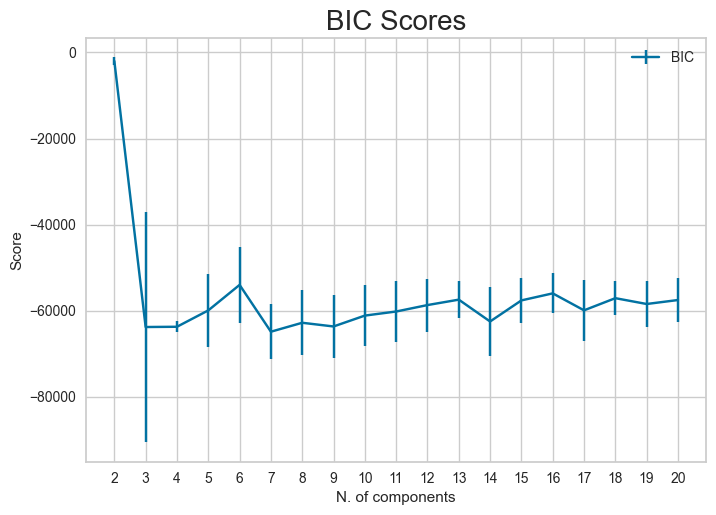

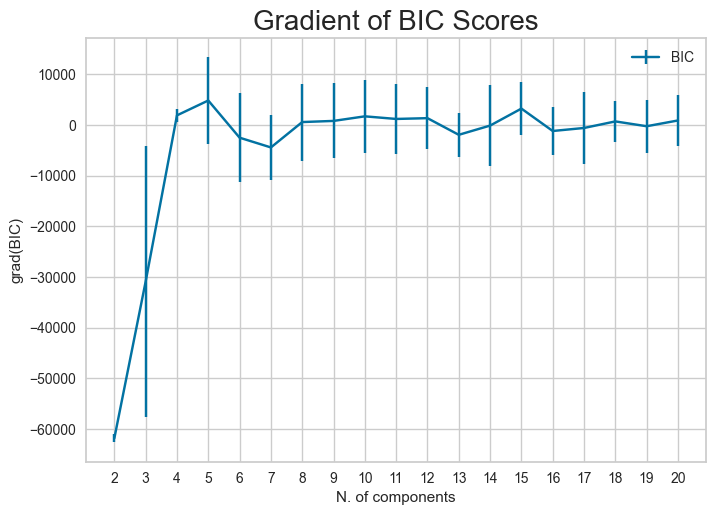

<Figure size 800x550 with 0 Axes>

In [116]:
generate_bic_plot(X, 21)

# Personal Loan Dataset

The dataset originates from a Thera Bank initiative aimed at converting liability customers into personal loan customers while retaining them as depositors. The campaign resulted in a successful conversion rate of over 9\%, which has motivated the retail marketing department to create more effective targeted marketing campaigns with a minimal budget to enhance the success rate.
	
The Personal Loan Dataset encompasses information on 5,000 customers, including demographic details such as age and income, the customer's relationship with the bank such as a mortgage or securities account, and their response to the previous personal loan campaign. Out of the 5,000 customers, only 480 (9.6\%) agreed to take up the personal loan offer during the campaign. In other words, this dataset is not balanced. 

## KMeans 

In [121]:
X, y = load_data('bank_personal_loan_modelling.csv')

Figure shows a plot of the silhoutte scores for each k value from 2 to 21. k=3 had the maximum silhoutte score of ~0.675 with a very low error rate. 

C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

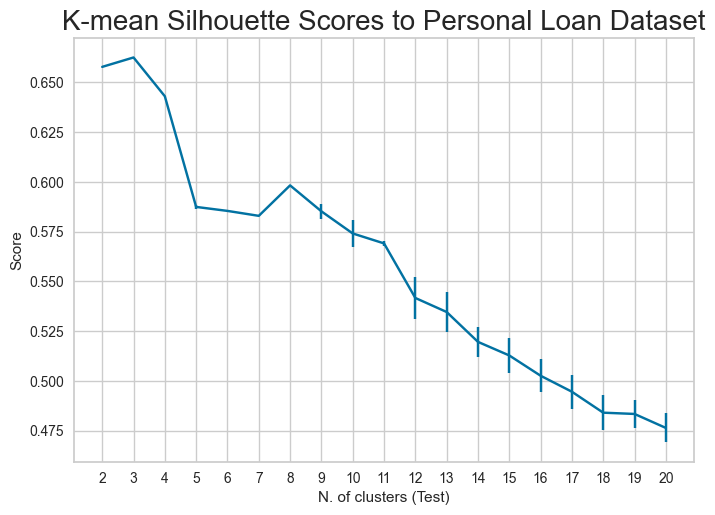

In [122]:
generate_silhoutte_score_plot(X, 21, KMeans)

Figure and figure show that there is indeed there is overlapping between several clusters. One would expect the ideal number of clusters to be 2 in the case of a tic tac toe game, where we have 9 features, each of which describes a square on the board and the overall state. It is also interesting to note that the ideal value for k, which is 8, is close to the number of features we have. These features also are restricted to values of -1, 0, and 1, which might make it more difficult to make distinct clusters

C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\ma

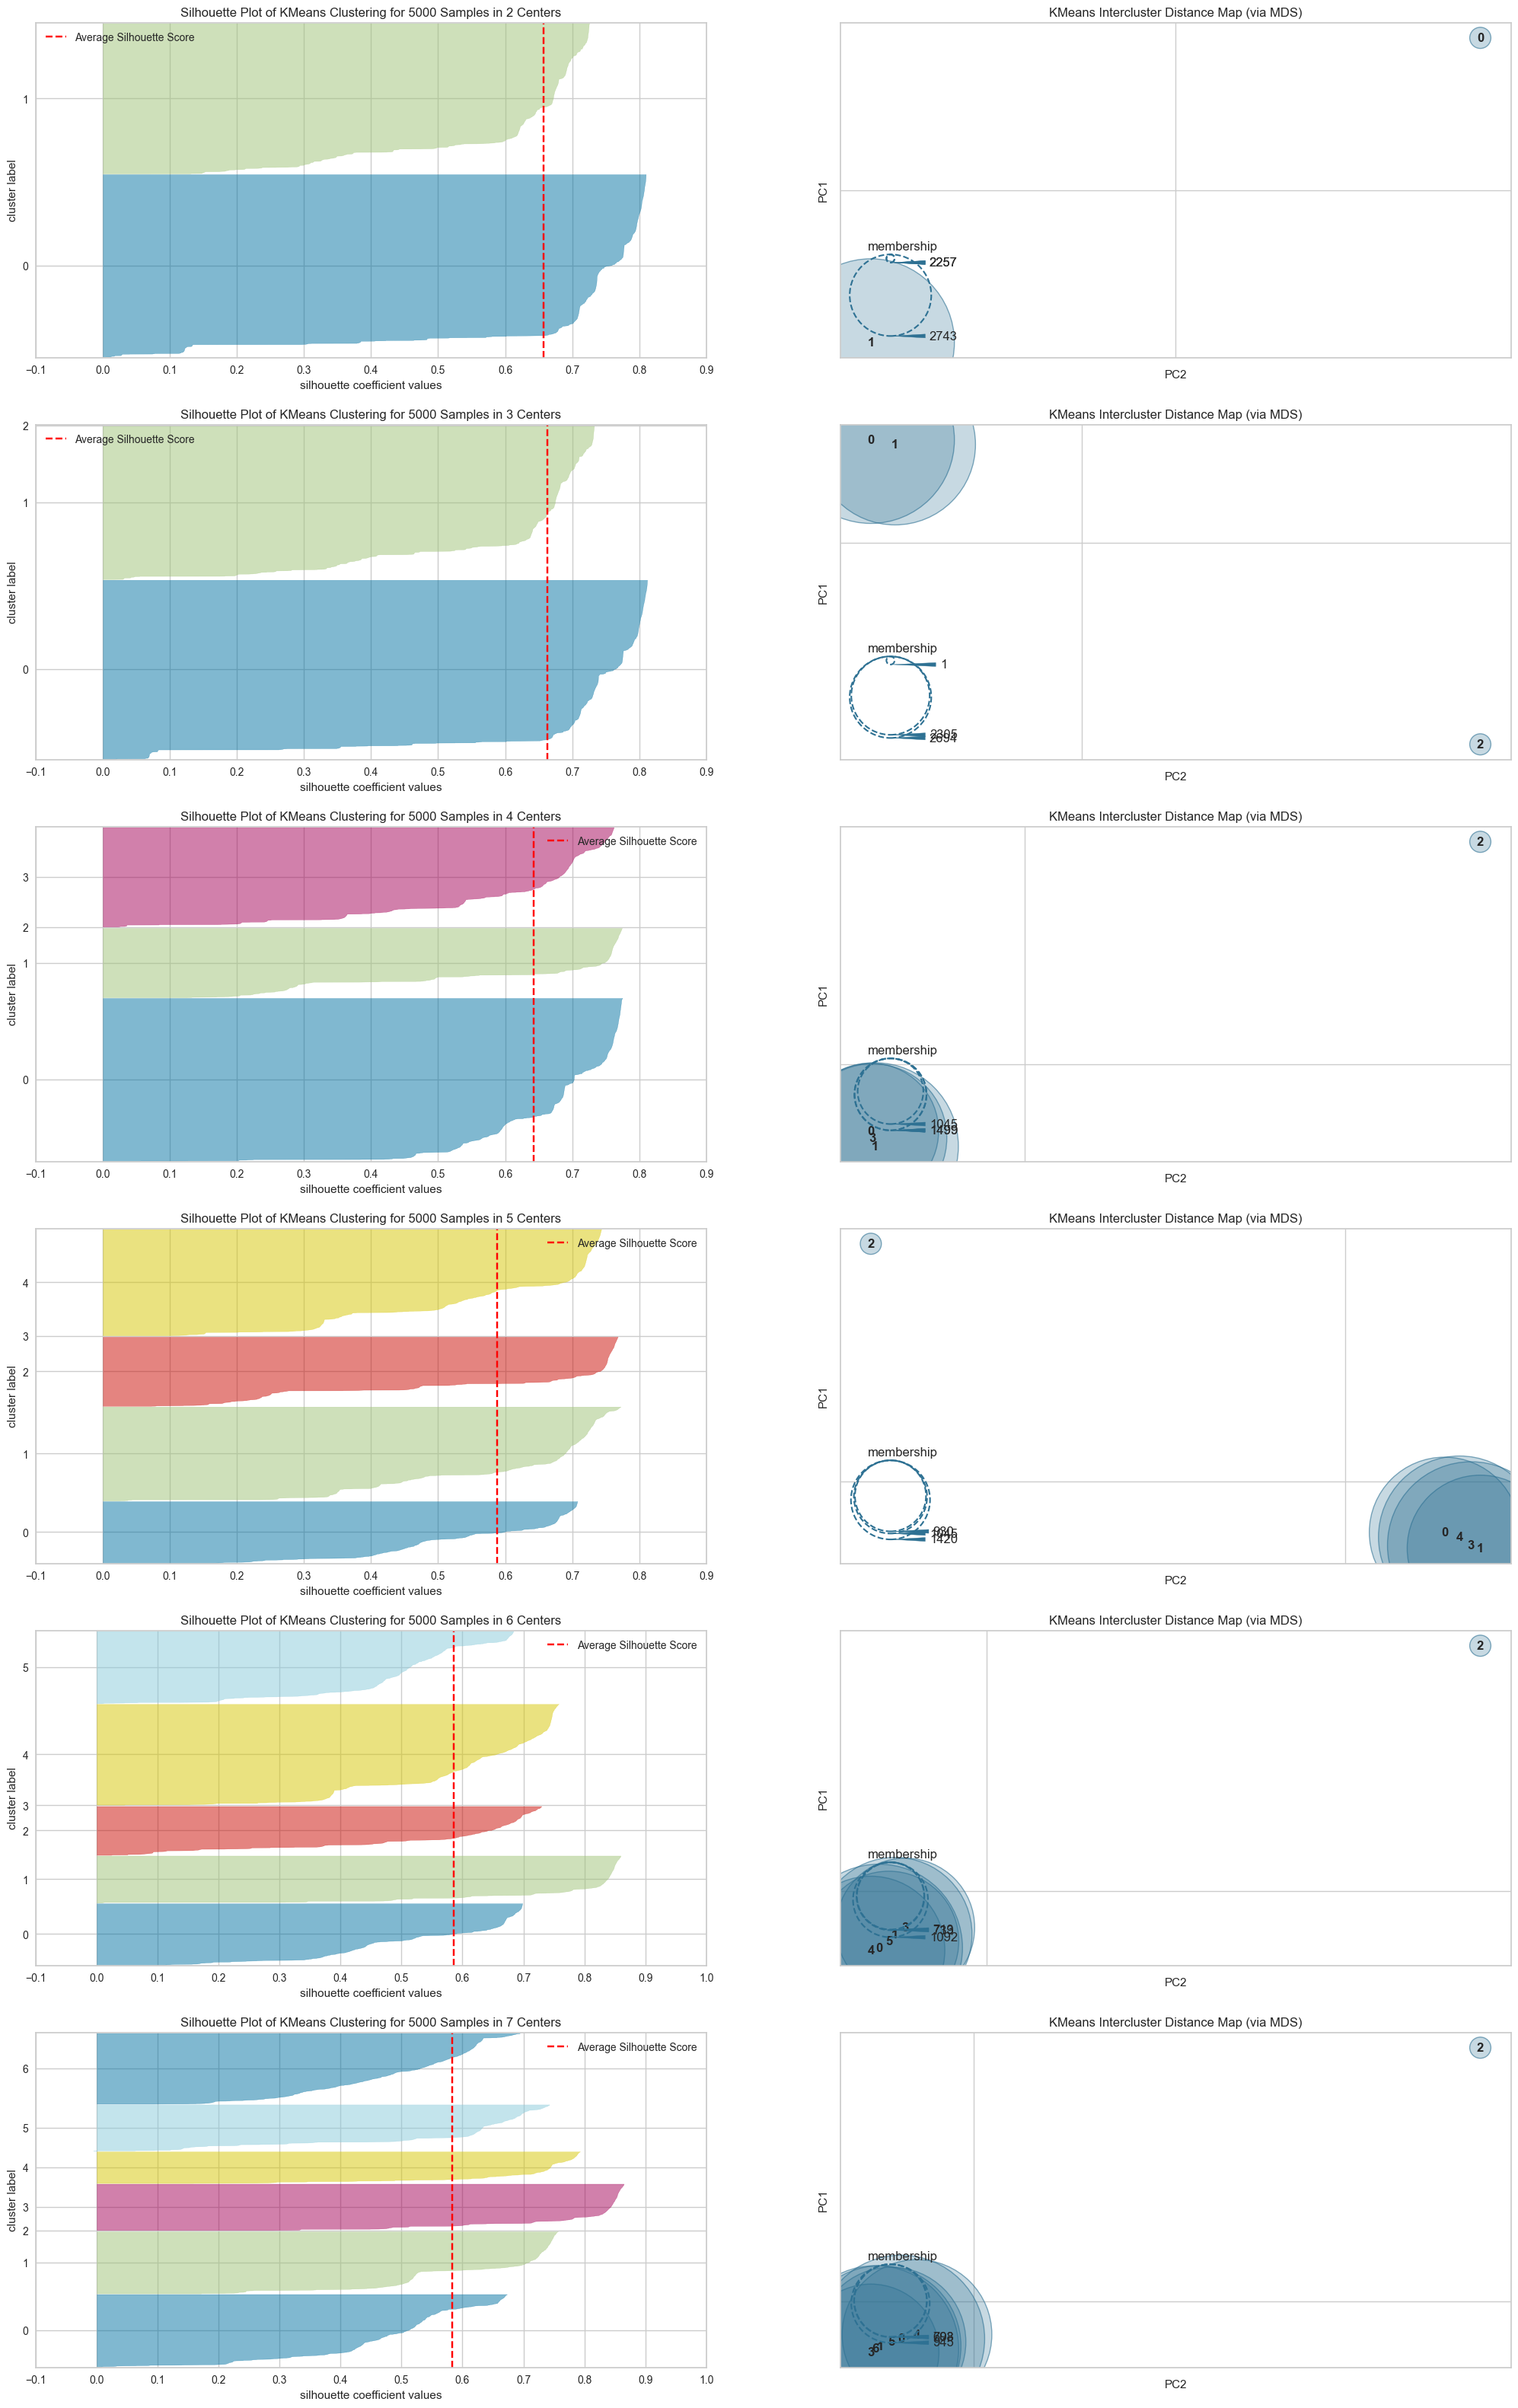

In [ ]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X, k)

# Expected Maximization

In [123]:
X, y = load_data('bank_personal_loan_modelling.csv')

Silhoutte score indicates 2 clusters, Distance indicates 3, 

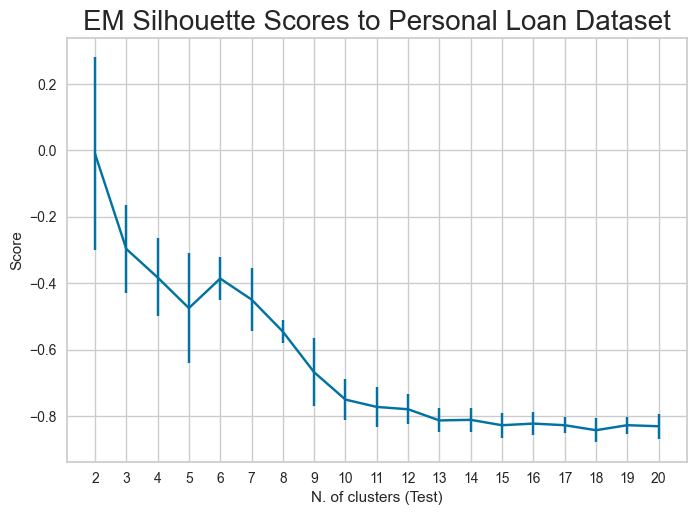

In [127]:
generate_silhoutte_score_plot(X, 21, GaussianMixture)

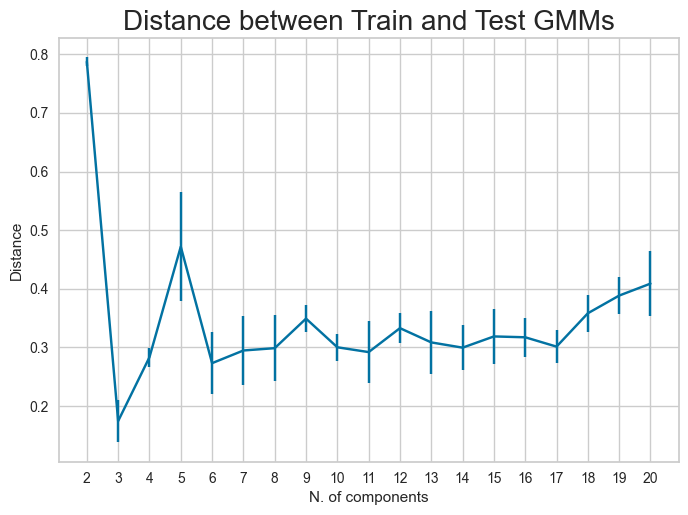

In [128]:
generate_distance_bw_gmms_plots(X, 21)

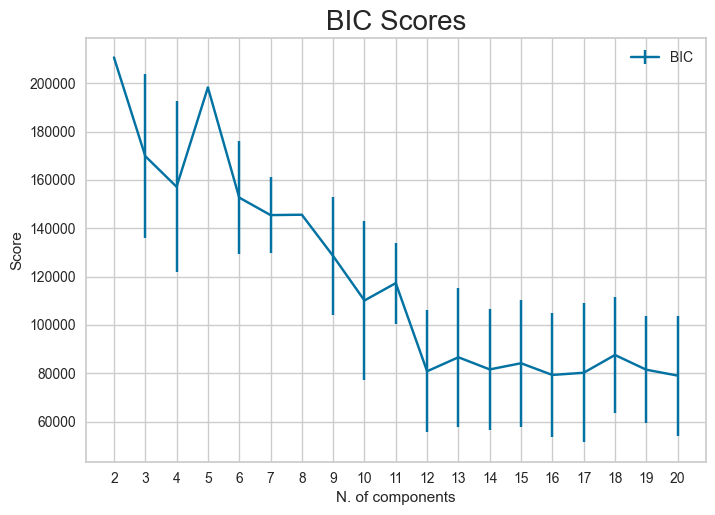

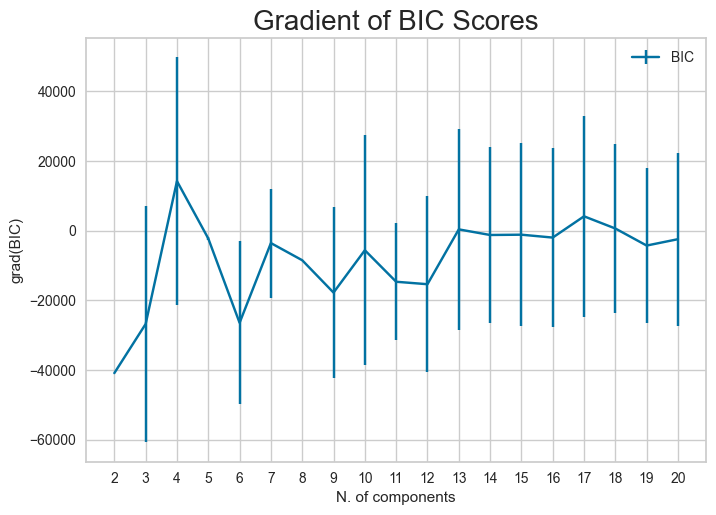

<Figure size 800x550 with 0 Axes>

In [129]:
generate_bic_plot(X, 21)

In [ ]:
# KMeans BC Data, k = 2
# Expected Maximization BC Data, n = 2
# KMeans TTT Data, k = 8
# Expected Maximization TTT Data, n = 2

# Train and Query Times

## Audit Risk Dataset

C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

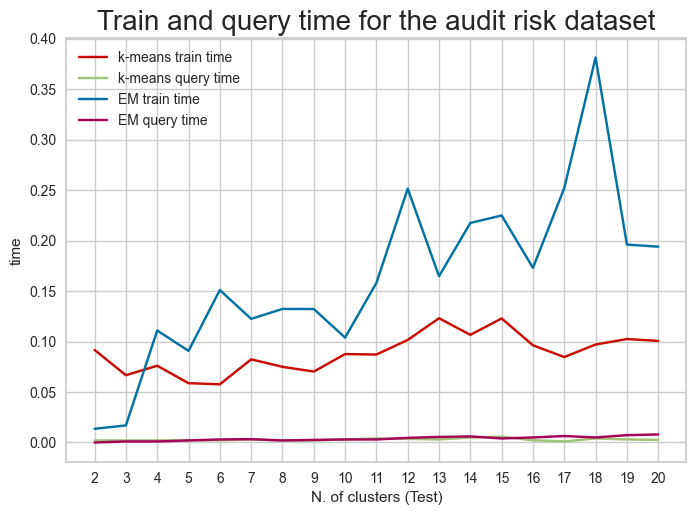

In [ ]:
X, y = load_data("audit_risk.csv")
generate_audit_time_plot(X, 21)

## Personal Loan Dataset

C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

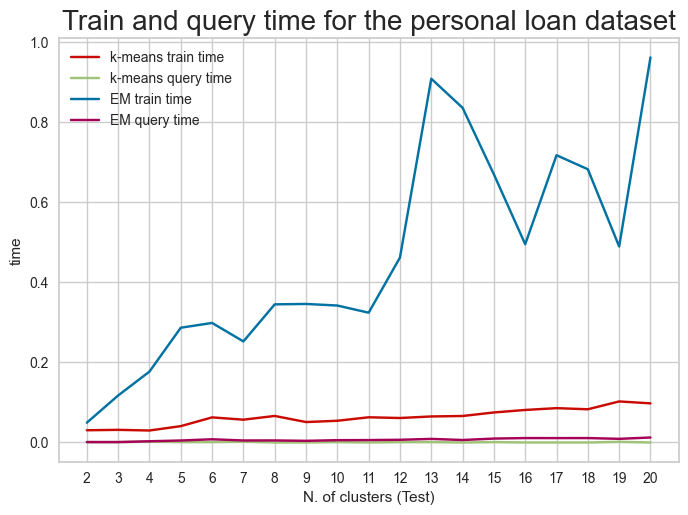

In [131]:
X, y = load_data("bank_personal_loan_modelling.csv")
generate_loan_time_plot(X, 21)

In [135]:
X, y = load_data("bank_personal_loan_modelling.csv")

clf=GaussianMixture(2).fit(X) 
labels=clf.predict(X)
pd.DataFrame(labels).to_csv("C:/Users/chang/file.csv")